## MODELO AR CON FTSE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

## modificamos fechas a indices, arreglamos la frecuencia a busines, y llenamos los huecos

In [3]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [4]:
df_comp['market_value']=df_comp.ftse #ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [6]:
import statsmodels.tsa.stattools as sts 
sts.adfuller(df.market_value)


(-1.9041551418836855,
 0.33010893277028364,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

## Medimos la Autocorrelacion

se obteine algo muy parecido al SP500. todos los coeficientes son significativos y disminuyen lentamente. Todos son positivos.
Siempre elegiremos modelos simples, ya que evitan sobreajuste. Muchos retrasos aprende muy bien el training test - overfitting

ACF captura efectos directos e indirectos - solo queremos considerar retrasos que tengan un efecto directo.
En general PACF nos da eso de forma mas relevante

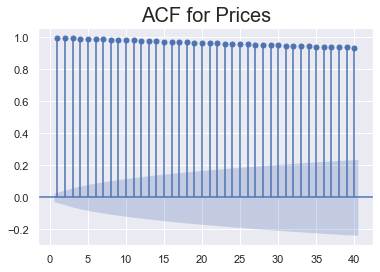

In [7]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size = 20)
plt.show()

## The PACF
Aqui salen coeficientes que la mayoria no son significativos.

A partir del restrado 20 - asumimos que son 0 y por tanto  no son relevantes.
Hay retrasos negativos - la frecuencia son dias habiles (que son como 22) puede haber cambios ciclicos cada mes, los valores de hace un mes afectan a los de hoy.
EL primer retraso tiene mucho mas impacto que cualquiera que los demas

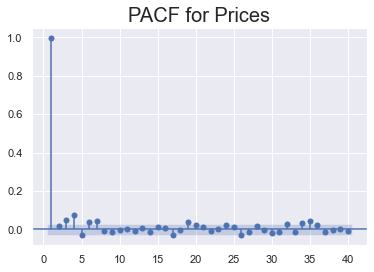

In [21]:
sgt.plot_pacf(df.market_value, lags = 40,  zero = False, method = ('ols'))
plt.title("PACF for Prices", size = 20)
plt.show()

## The AR(1) Model

Modelo AR de orden 1 - ya que hemos vistoque 1 retraso tiene mucho peso.
El meto ARMA consirea modelos AR y MA, el MA se puede anular poniendolo a 0 y dando valores a la parte de AR.
Vale con dar el argumento de orden a AR (el numero de valores pasados que va a considerar)

Hay que hacer un fit del modelo para crearlo.

In [8]:
model_ar = ARMA(df.market_value, order=(1,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [23]:
results_ar = model_ar.fit()

SUMMARY presenta la tabla con el resumen del modelo

const y ar.L1 son los coeficientes (L1 es el retraso (lack) 1)

Primero va el valor del modelo segun el metodo

La siguiente columna son los errores estandar (depende de la muestra que se tome)

z es el valor del estadistico de prueba para ver la significacion de las estimaciones (son un contraste de hipotesis)
La hipotesis nula es que el coefieciente es significativamente =0

El p valor es pequeño (probabilidad de la hipotesis nula) se puede rechazar la hipoitesis, por lo tanto el coeficiente es significativo (en general se compara con 0.05). 

Otra forma de verlo es el intervalo de confianza, si contiene a 0 no se rechaza H0, el coeficiente seria 0. Si no contiene 0 rechzamos H1 y el coeficiente es significativo y distinto de 0.

In [24]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.599
Method:                       css-mle   S.D. of innovations             59.258
Date:                Wed, 29 Mar 2023   AIC                          55251.197
Time:                        18:30:42   BIC                          55270.761
Sample:                    01-07-1994   HQIC                         55258.053
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5061.6345    486.424     10.406      0.000    4108.261    6015.008
ar.L1.market_value     0.9985      0.001   1298.755      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

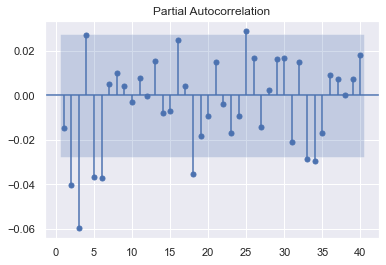

In [25]:

sgt.plot_pacf(results_ar.resid, lags = 40,  zero = False, method = ('ols'))
plt.show()

# todavia queda señal ....

## AR de Grado mas elevado

Retraso de dos periodos - determinamos los precios de hoy con los precios de los dos dias anteriores

Se busca que al añadir informacion ,AIC y BIC disminuyan y LL (log Likelihood) aumente ... eso implica una mejora del modelo...
  

In [9]:
model_ar_2 = ARMA(df.market_value, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

#cte- l1 - l2 - coeficientes asociados a x-1 y x-2
# las ctes l1 y k2 cambian se reestiman no son los mismos que los anteriores
#p <0.05 es significatico
# l2 no es significativamente diferente de 0 - asumimos que es 0
# el precio de hace dos dias no afecta a los de hoy
#por ejemplo que toda la informacion esta en el dato de ayer, añadir mas informacion no aporta
# mejor explorar de ordenes superiores

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.871
Method:                       css-mle   S.D. of innovations             59.249
Date:                Thu, 30 Mar 2023   AIC                          55251.742
Time:                        20:05:14   BIC                          55277.827
Sample:                    01-07-1994   HQIC                         55260.883
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6408    495.647     10.269      0.000    4118.190    6061.091
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4626           +0.0000j           58.4626            0.5000
-----------------------------------------------------------------------------
"""

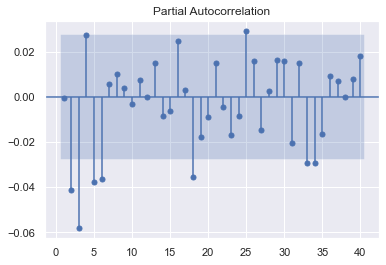

In [27]:

sgt.plot_pacf(results_ar_2.resid, lags = 40,  zero = False, method = ('ols'))
plt.show()

# todavia queda señal ....

In [10]:
# en teoria cuanta mas info mejores modelos, pero se corre el riesgo de overfittin y de alta complejidad

model_ar_3 = ARMA(df.market_value, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(3, 0)   Log Likelihood              -27615.869
Method:                       css-mle   S.D. of innovations             59.178
Date:                Thu, 30 Mar 2023   AIC                          55241.738
Time:                        20:07:33   BIC                          55274.345
Sample:                    01-07-1994   HQIC                         55253.164
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5077.2885    517.182      9.817      0.000    4063.630    6090.947
ar.L1.market_value     0.9806      0.014     69.619      0.000       0.953       1.008
ar.L2.market_value    -0.0309      0.020     -1.564      0.118      -0.070       0.008
ar.L3.market_value     0.0489      0.014      3.466      0.001       0.021       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           -0.0000j            1.0013           -0.0000
AR.2           -0.1848           -4.5159j            4.5197           -0.2565
AR.3           -0.1848           +4.5159j            4.5197            0.2565
-----------------------------------------------------------------------------
"""

In [29]:
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Wed, 29 Mar 2023   AIC                          55217.130
Time:                        18:30:47   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    559.971      9.089      0.000    3992.119    6187.164
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value    -0.0286      0.020     -1.455      0.146      -0.067       0.010
ar.L3.market_value    -0.0224      0.020     -1.135      0.256      -0.061       0.016
ar.L4.market_value     0.0728      0.014      5.166      0.000       0.045       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0011           -0.0000j            1.0011           -0.0000
AR.2            0.9550           -2.0884j            2.2964           -0.1817
AR.3            0.9550           +2.0884j            2.2964            0.1817
AR.4           -2.6036           -0.0000j            2.6036           -0.5000
-----------------------------------------------------------------------------
"""

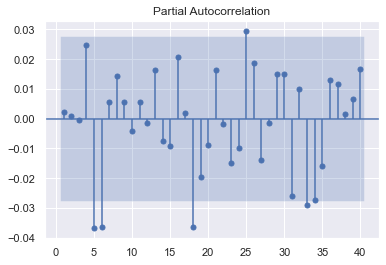

In [30]:

sgt.plot_pacf(results_ar_4.resid, lags = 40,  zero = False, method = ('ols'))
plt.show()

# todavia queda señal ....

A mas complejidad mas aumenta el logaritmo de la verosimilud (al ser negativo) (log likelihood)

A mas complejidad mas log likelihood - en general se prefiren algorimot con mas log likelihood siempre que compense la complejidad

Si vemos AIX y BIC vemos que van disminuyendo - en general preferiremos valores mas bajos de esos dos criterios

log-likelihood ratio test LLR Test mide si dos modelos son significativamente diferentes: se puede hacer sobre dos modelos y devuelve un p valor para rechazar H0 o no

## LLR Test
https://en.wikipedia.org/wiki/Likelihood-ratio_test. In statistics, the likelihood-ratio test assesses the goodness of fit of two competing statistical models based on the ratio of their likelihoods.

La H0 esque los modelos son significativamente iguales - y si se rechaza es que son diferentes.

LLR_test nos permite decidir si rechazar o no la hipotesis nula.

DF son los grados de libertad del estadistico, dependen entre la cantidad de parametros de los modelos. Entre modelo 1 y el 2 la diferencia es 1 (si no se ponde nada es 1, sino se pone la diferencia)

Se haya el LLF de vada modelo, esl estadistico es 2 veces la diferencia  entre modelos 2 - modelos 1 ( el segundo modelo es el mas complejo)

p - se compara con las ditribucion del estadistico (que es la chi2), se pone el LR y los grados de libertad y se redondea

si p<0.05 se puede rechazar H0 - es decir que los dos modelos son distintos

sino nos quedamos con el mas simple


In [31]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## Comparing Higher-Lag AR Models

In [32]:
LLR_test(results_ar, results_ar_2)

0.228

In [33]:
LLR_test(results_ar_2, results_ar_3)
# se rechaza la hipotesis nula - os modelos son significativamente diferentes, i.e. añadir complejidad mejora el modelo, es mejor el 3

0.001

In [34]:
LLR_test(results_ar, results_ar_3, DF=2)

0.001

In [35]:
model_ar_4 = ARMA(df.market_value, order=[4,0])
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary()) 
print ("LLR test: " + str(LLR_test(results_ar_3, results_ar_4)))

# seguimos subiendo LL y bajando AIC

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(4, 0)   Log Likelihood              -27602.565
Method:                       css-mle   S.D. of innovations             59.022
Date:                Wed, 29 Mar 2023   AIC                          55217.130
Time:                        18:30:50   BIC                          55256.258
Sample:                    01-07-1994   HQIC                         55230.841
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    559.971      9.089      0.000    3992.119    6187.164
ar.L1.market_value     0.9770      0.014     69.492      0.000       0.949       1.005
ar.L2.market_value  

In [36]:


model_ar_5 = ARMA(df.market_value, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))

# hay que mirar que el ULTIMO coeficiente sea significativo (los anteriores pueden cambiar y no serlo)
# y que el p-valor sea significativo para ver que se mejora
# nos quedamos con el 5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 0)   Log Likelihood              -27600.348
Method:                       css-mle   S.D. of innovations             58.996
Date:                Wed, 29 Mar 2023   AIC                          55214.697
Time:                        18:30:52   BIC                          55260.346
Sample:                    01-07-1994   HQIC                         55230.693
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    543.578      9.363      0.000    4024.248    6155.034
ar.L1.market_value     0.9791      0.014     69.481      0.000       0.952       1.007
ar.L2.market_value  

In [37]:
model_ar_6 = ARMA(df.market_value, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 0)   Log Likelihood              -27596.474
Method:                       css-mle   S.D. of innovations             58.950
Date:                Wed, 29 Mar 2023   AIC                          55208.947
Time:                        18:30:54   BIC                          55261.118
Sample:                    01-07-1994   HQIC                         55227.229
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    565.211      9.005      0.000    3981.849    6197.434
ar.L1.market_value     0.9803      0.014     69.604      0.000       0.953       1.008
ar.L2.market_value  

In [38]:
model_ar_7 = ARMA(df.market_value, order=(7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Wed, 29 Mar 2023   AIC                          55201.799
Time:                        18:30:58   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6413    589.560      8.633      0.000    3934.125    6245.157
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

In [39]:
model_ar_8 = ARMA(df.market_value, order=(8,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_7, results_ar_8)))

# ya no es significativo para 8 - el coeficiente seria 0 
# ademasel p -valor tambien dice que no mejora
# nos quedamos entonces con el modelo 7
# incluir precios de 8 dias no mejora pero 7 dias si mejora
# mnos quedamos con el 7 aunque tiene coeficientes cno significativos...

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Wed, 29 Mar 2023   AIC                          55203.478
Time:                        18:31:09   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6410    585.004      8.700      0.000    3943.054    6236.228
ar.L1.market_value     0.9790      0.014     69.476      0.000       0.951       1.007
ar.L2.market_value  

In [40]:
# comparamos el de 7 con el de 1 a ver si es significativo y mejora 
# ojo a los grados de libertad

# EL modelo tiene coeficientes no significativos lo cual puede ser un problema.
# los mosloes AR funcionan bien para modelos estacionarios - pero no tan bien para ST no estacionarias

# Si se mira Dickey Fuller se ve que no es estacionario
#se pueden aplicar transformaciones


print("LLR test: " + str(LLR_test(results_ar, results_ar_7, DF = 6)))

print("LLR test: " + str(LLR_test(results_ar_3, results_ar_7, DF = 4)))

LLR test: 0.0
LLR test: 0.0


## Analysing the Residuals

esto es importante ver que queda ruido blanco
no debe haber autocorrelaciaon y en el test de DF se deberia ver que es estacionario

In [41]:
df['res_price'] = results_ar_7.resid

C:\Users\enriq\AppData\Local\Temp/ipykernel_36708/794269739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_price'] = results_ar_7.resid


In [42]:
sts.adfuller(df.res_price)

#p (el segundo es 0) se rechaza la hipotesis de que no son estacionarios - son estacionarios

(-76.07468107926283,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 54842.41504269652)

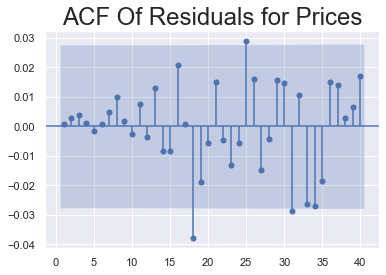

In [43]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

# no debe haber autocorrelacion - y vemos que no la hay que no es significativo

#es ruido blanco y AR(7) ha cogido todas las tendencias
# algunos puntos si salen del azul, asi que eso indica que puede haber un mejor predictor

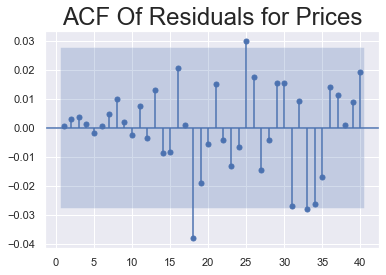

In [44]:
sgt.plot_pacf(df.res_price, zero = False, lags = 40, method ='ols')
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

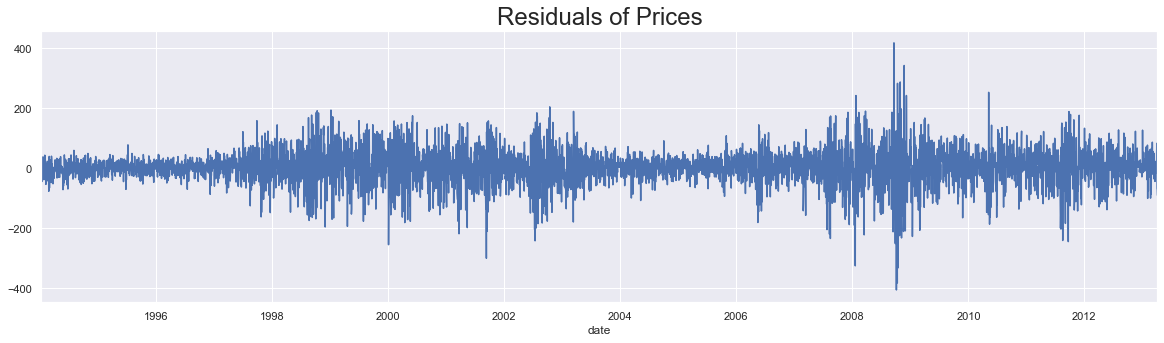

In [45]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

# no hay patron (o casi no hay)

In [46]:
# de el modelo con tres retraso - pues el ruido no es ruido blanco

In [47]:
df['res_price'] = results_ar_3.resid
sts.adfuller(df.res_price)


C:\Users\enriq\AppData\Local\Temp/ipykernel_36708/2127096544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_price'] = results_ar_3.resid


(-31.87385286107707,
 0.0,
 5,
 5015,
 {'1%': -3.431654616214729,
  '5%': -2.862116499672828,
  '10%': -2.567076871409699},
 54852.72266277029)

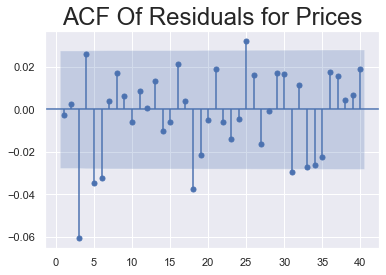

In [48]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

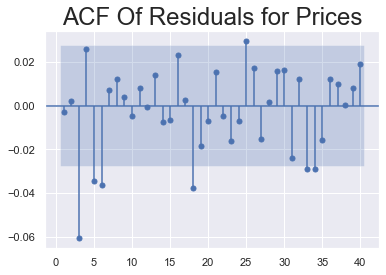

In [49]:
sgt.plot_pacf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

 ###  USO DE RETORNOS PARA FTSE

In [50]:
sts.adfuller(df.market_value)

#FTSe no es estacionaria - por eso daba esos probleams al usar AR que funciona bien con estacionarias

# en ST de valores, se puede usar una transformacion para que sean estacionarias, el porcentage de cambio

(-1.9041551418836855,
 0.33010893277028364,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

In [51]:
#en este caso % de cambio de un dia para otro

In [52]:
df['returns']=df.market_value.pct_change(1).mul(100)
df=df.iloc[1:]

# descartamos el primero porque el retorno necesita el precio del dia anterior asi que no hay retorno del primer dia, 
#por eso lo eliminamos de todos, se puede ver con df.head()

# se multiplica por 100 para el % sino seria 0.2
# pct_change obtiene el porcentage de cambio entre el periodo actual y le anterior (es el 1, es el defecto se podria no poner)

C:\Users\enriq\AppData\Local\Temp/ipykernel_36708/2560602096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df.market_value.pct_change(1).mul(100)


In [53]:
sts.adfuller(df.returns)

# AHORA YA ES ESTACIONARIO, SE RECHAZA H0
# Y PODEMOS TRABAJAR COMO ANTES PERO CON ESTA SERIE DERIVADA....

(-12.770265719497296,
 7.798058336036148e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

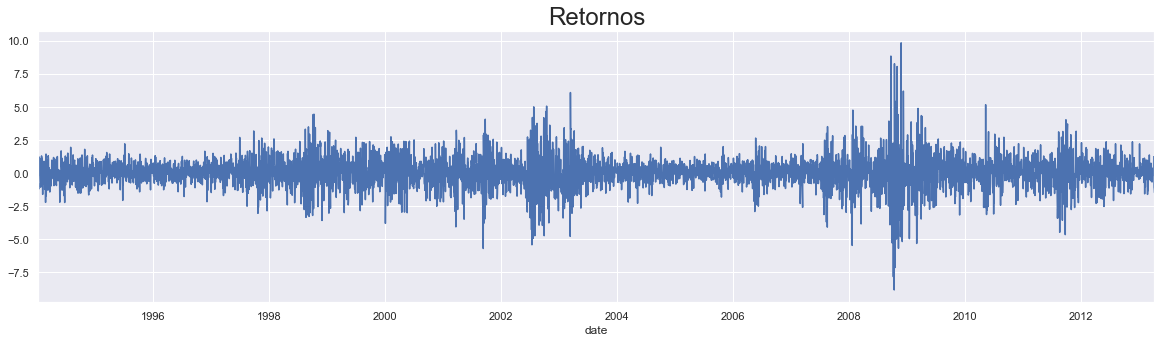

In [54]:
df.returns[1:].plot(figsize=(20,5))
plt.title("Retornos",size=24)
plt.show()


### ACF Y PACF PARA RETORNOS

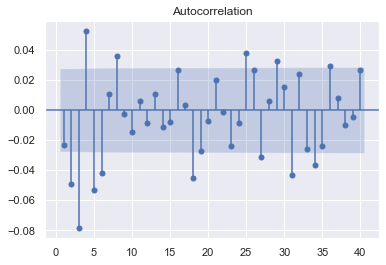

In [55]:
sgt.plot_acf(df.returns, zero = False, lags = 40)

plt.show()

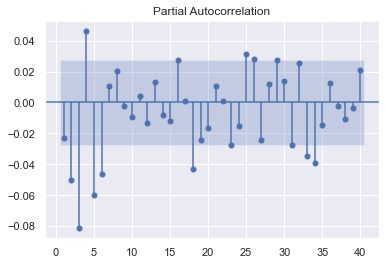

In [56]:
sgt.plot_pacf(df.returns, lags = 40,  zero = False, method = ('ols'))
plt.show()

Si queremos un modelo autorregresivo, ¿en cuál de ellas nos fijaríamos? ¿Por qué?

Nos fijamos en el gráfico de la función de autocorrelación parcial, PACF, porque es la que recoge la información sobre la influencia directa de una observación con k retrasos sobre la observación actual, que es justamente en lo que se fundamenta un modelo Autorregresivo.

¿Cuántos retrasos crees que deberíamos investigar para el modelo autorregresivo y por qué?
Observando el gráfico de la función de autocorrelación parcial, PACF, podemos observar que a partir del 6º retraso, empezamos a tener influencia no significativa, por lo que, seguramente, si queremos ajustar un modelo AR, deberemos escoger un AR(6).


#### AR(1) retornos

###AR(p) de alto orden

##repetir lo del caso anterior para ver como da

In [57]:
model_ar_ret1 = ARMA(df.returns, order=(1,0))
results_ar_ret1 = model_ar_ret1.fit()
results_ar_ret1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Wed, 29 Mar 2023   AIC                          15865.497
Time:                        18:52:28   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

In [58]:
model_ar_ret2 = ARMA(df.returns, order=(2,0))
results_ar_ret2 = model_ar_ret2.fit()
results_ar_ret2.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Wed, 29 Mar 2023   AIC                          15854.911
Time:                        18:52:28   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [59]:
model_ar_ret3 = ARMA(df.returns, order=(3,0))
results_ar_ret3 = model_ar_ret3.fit()
results_ar_ret3.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Wed, 29 Mar 2023   AIC                          15823.477
Time:                        18:52:29   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.returns    -0.0521      0.014     -3.705      0.000      -0.080      -0.025
ar.L3.returns    -0.0815      0.014     -5.792      0.000      -0.109      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9233           -2.0210j            2.2219           -0.1818
AR.2            0.9233           +2.0210j            2.2219            0.1818
AR.3           -2.4855           -0.0000j            2.4855           -0.5000
-----------------------------------------------------------------------------
"""

In [60]:
model_ar_ret4 = ARMA(df.returns, order=(4,0))
results_ar_ret4 = model_ar_ret4.fit()
results_ar_ret4.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(4, 0)   Log Likelihood               -7901.330
Method:                       css-mle   S.D. of innovations              1.168
Date:                Wed, 29 Mar 2023   AIC                          15814.661
Time:                        18:52:30   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.267      0.205      -0.010       0.048
ar.L1.returns    -0.0245      0.014     -1.739      0.082      -0.052       0.003
ar.L2.returns    -0.0496      0.014     -3.531      0.000      -0.077      -0.022
ar.L3.returns    -0.0802      0.014     -5.701      0.000      -0.108      -0.053
ar.L4.returns     0.0464      0.014      3.291      0.001       0.019       0.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8888           -0.0000j            1.8888           -0.5000
AR.2            0.3231           -1.9331j            1.9599           -0.2236
AR.3            0.3231           +1.9331j            1.9599            0.2236
AR.4            2.9701           -0.0000j            2.9701           -0.0000
-----------------------------------------------------------------------------
"""

In [61]:
model_ar_ret5 = ARMA(df.returns, order=(5,0))
results_ar_ret5 = model_ar_ret5.fit()
results_ar_ret5.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 0)   Log Likelihood               -7892.390
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 29 Mar 2023   AIC                          15798.779
Time:                        18:52:30   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.348      0.178      -0.009       0.046
ar.L1.returns    -0.0217      0.014     -1.544      0.123      -0.049       0.006
ar.L2.returns    -0.0544      0.014     -3.865      0.000      -0.082      -0.027
ar.L3.returns    -0.0831      0.014     -5.914      0.000      -0.111      -0.056
ar.L4.returns     0.0449      0.014      3.190      0.001       0.017       0.073
ar.L5.returns    -0.0596      0.014     -4.232      0.000      -0.087      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5481           -0.0000j            1.5481           -0.5000
AR.2           -0.2860           -1.7252j            1.7487           -0.2761
AR.3           -0.2860           +1.7252j            1.7487            0.2761
AR.4            1.4366           -1.2157j            1.8819           -0.1118
AR.5            1.4366           +1.2157j            1.8819            0.1118
-----------------------------------------------------------------------------
"""

In [62]:
model_ar_ret6 = ARMA(df.returns, order=(6,0))
results_ar_ret6 = model_ar_ret6.fit()
results_ar_ret6.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Wed, 29 Mar 2023   AIC                          15789.890
Time:                        18:52:31   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     -3.716      0.000      -0.080      -0.025
ar.L3.returns    -0.0870      0.014     -6.174      0.000      -0.115      -0.059
ar.L4.returns     0.0424      0.014      3.009      0.003       0.015       0.070
ar.L5.returns    -0.0607      0.014     -4.309      0.000      -0.088      -0.033
ar.L6.returns    -0.0466      0.014     -3.302      0.001      -0.074      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2869           -0.9022j            1.5716           -0.0973
AR.2            1.2869           +0.9022j            1.5716            0.0973
AR.3           -0.0727           -1.5282j            1.5299           -0.2576
AR.4           -0.0727           +1.5282j            1.5299            0.2576
AR.5           -1.8659           -0.4836j            1.9275           -0.4596
AR.6           -1.8659           +0.4836j            1.9275            0.4596
-----------------------------------------------------------------------------
"""

In [63]:
model_ar_ret7 = ARMA(df.returns, order=(7,0))
results_ar_ret7 = model_ar_ret7.fit()
results_ar_ret7.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Wed, 29 Mar 2023   AIC                          15791.294
Time:                        18:52:33   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.returns    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.returns     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.returns    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.returns    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.returns     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2269           -0.0000j            5.2269           -0.0000
-----------------------------------------------------------------------------
"""

In [64]:
df['res_ret'] = results_ar_ret6.resid
sts.adfuller(df.res_price)



(-31.627012570422664,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54842.728015171095)

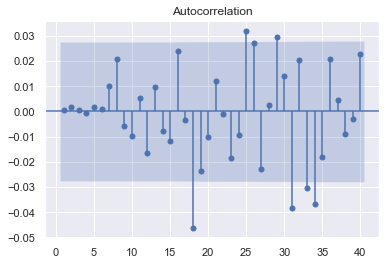

In [65]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)

plt.show()

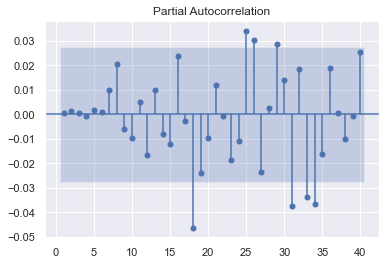

In [66]:
sgt.plot_pacf(df.res_ret, zero = False, lags = 40)

plt.show()

In [67]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret1, results_ar_ret2)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret2, results_ar_ret3)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret3, results_ar_ret4)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret4, results_ar_ret5)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret5, results_ar_ret6)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret6, results_ar_ret7)))

print("\nLLR test p-value = " + str(LLR_test(results_ar_ret1, results_ar_ret6, DF=5)))
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret1, results_ar_ret7, DF=6)))




LLR test p-value = 0.0

LLR test p-value = 0.0

LLR test p-value = 0.001

LLR test p-value = 0.0

LLR test p-value = 0.001

LLR test p-value = 0.44

LLR test p-value = 0.0

LLR test p-value = 0.0


In [70]:
model_ar_18 = ARMA(df.returns, order=(18,0))
results_ar_18 = model_ar_18.fit()
results_ar_18.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                    ARMA(18, 0)   Log Likelihood               -7877.401
Method:                       css-mle   S.D. of innovations              1.162
Date:                Wed, 29 Mar 2023   AIC                          15794.801
Time:                        19:29:26   BIC                          15925.225
Sample:                    01-10-1994   HQIC                         15840.503
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0189      0.013      1.430      0.153      -0.007       0.045
ar.L1.returns     -0.0236      0.014     -1.674      0.094      -0.051       0.004
ar.L2.returns     -0.0492      0.014     -3.487      0.000      -0.077      -0.022
ar.L3.returns     -0.0871      0.014     -6.170      0.000      -0.115      -0.059
ar.L4.returns      0.0422      0.014      2.981      0.003       0.014       0.070
ar.L5.returns     -0.0583      0.014     -4.112      0.000      -0.086      -0.031
ar.L6.returns     -0.0458      0.014     -3.222      0.001      -0.074      -0.018
ar.L7.returns      0.0108      0.014      0.763      0.446      -0.017       0.039
ar.L8.returns      0.0204      0.014      1.437      0.151      -0.007       0.048
ar.L9.returns     -0.0053      0.014     -0.371      0.711      -0.033       0.023
ar.L10.returns    -0.0069      0.014     -0.484      0.628      -0.035       0.021
ar.L11.returns     0.0066      0.014      0.462      0.644      -0.021       0.034
ar.L12.returns    -0.0175      0.014     -1.228      0.219      -0.045       0.010
ar.L13.returns     0.0119      0.014      0.840      0.401      -0.016       0.040
ar.L14.returns    -0.0048      0.014     -0.340      0.734      -0.033       0.023
ar.L15.returns    -0.0149      0.014     -1.054      0.292      -0.043       0.013
ar.L16.returns     0.0253      0.014      1.792      0.073      -0.002       0.053
ar.L17.returns    -0.0003      0.014     -0.025      0.980      -0.028       0.027
ar.L18.returns    -0.0431      0.014     -3.055      0.002      -0.071      -0.015
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1897           -0.2016j            1.2067           -0.4733
AR.2            -1.1897           +0.2016j            1.2067            0.4733
AR.3            -1.0909           -0.5629j            1.2276           -0.4242
AR.4            -1.0909           +0.5629j            1.2276            0.4242
AR.5            -0.7909           -0.8750j            1.1795           -0.3670
AR.6            -0.7909           +0.8750j            1.1795            0.3670
AR.7            -0.3788           -1.0977j            1.1612           -0.3029
AR.8            -0.3788           +1.0977j            1.1612            0.3029
AR.9             0.0079           -1.1458j            1.1458           -0.2489
AR.10            0.0079           +1.1458j            1.1458            0.2489
AR.11            0.4175           -1.1147j            1.1903           -0.1930
AR.12            0.4175           +1.1147j            1.1903            0.1930
AR.13            0.7788           -0.8900j            1.1826           -0.1356
AR.14            0.7788           +0.8900j            1.1826            

In [71]:
df['res_ret18'] = results_ar_18.resid


In [72]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_ret6, results_ar_18, DF=12)))

# NO LO MEJORA
# ADEMAS 18 son muchos retrasos para considerar - 


LLR test p-value = 0.086


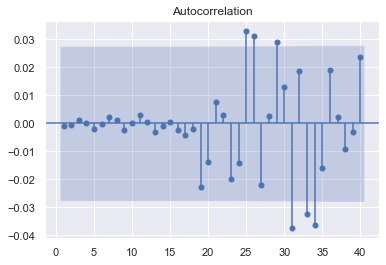

In [73]:
sgt.plot_acf(df.res_ret18, zero = False, lags = 40)
plt.show()

In [69]:
from statsmodels.tsa.ar_model import AR,ARResults

model = AR(df.returns)
ARfit = model.fit(ic='bic', method='mle') # establece el criterio de seleccion demodelos
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Lag: 6
Coefficients:
const         0.023244
L1.returns   -0.024528
L2.returns   -0.052316
L3.returns   -0.086971
L4.returns    0.042384
L5.returns   -0.060676
L6.returns   -0.046556
dtype: float64
